# Evaluacin de Metricas 

En el presente Notebook se pretende analizar y comparar SSIM (Structural Similarity Index Measure), PSNR (Peack Signal Noise Ratio) y la Diferencia absoluta, como indicadores que permitan evaluar el rendimiento de un algoritmo alineador de fotogramas.

### Paso 1: Preparar Imagenes de Prueba 

Dado que SSIM trabaja con parametros como el brillo, el contraste y la esctructura de una imagen, parece competente someter a las tres metricas a las mismas codiciones. Para eso se obtienen cuatro imagenes a comparar, con diferentes rotaciones, translaciones, contraste y brillo con respecto a una imagen de referencia.

In [62]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def imshow(img, title=None):
    if img.shape[-1] == 3:  # Check if the image has 3 channels
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    elif img.shape[-1] == 4:  # Check if the image has 4 channels (e.g., RGBA)
        img = cv2.cvtColor(img, cv2.COLOR_BGRA2RGBA)

    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')  # Turn off axis labels and ticks
    plt.title(title)
    plt.show()

In [61]:
def extract_rotate_translate_window(image, window_width, window_height, title, gamma=0, dx=0, dy=0):
    # Get the center coordinates of the image
    image_center_x, image_center_y = image.shape[1] // 2, image.shape[0] // 2

    # Rotate the image from its center
    rotation_matrix = cv2.getRotationMatrix2D((image_center_x, image_center_y), gamma, 1)
    rotated_image = cv2.warpAffine(image, rotation_matrix, (image.shape[1], image.shape[0]))

        # Translate the rotated window
    translation_matrix = np.float32([[1, 0, dx], [0, 1, dy]])
    translated_window = cv2.warpAffine(rotated_image, translation_matrix, (image.shape[1], image.shape[0]))

    # Calculate the coordinates of the window's center
    window_center_x, window_center_y = image_center_x, image_center_y

    # Extract the window
    half_width = window_width // 2
    half_height = window_height // 2
    x1 = window_center_x - half_width
    x2 = window_center_x + half_width
    y1 = window_center_y - half_height
    y2 = window_center_y + half_height
    window = translated_window[y1:y2, x1:x2]


    imshow(window, title=title)
    return window

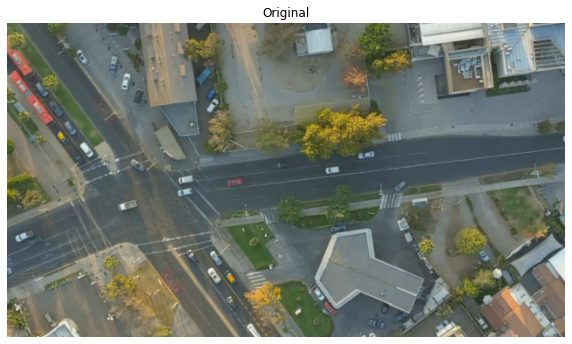

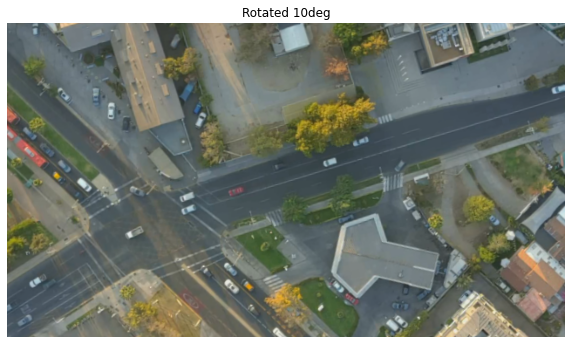

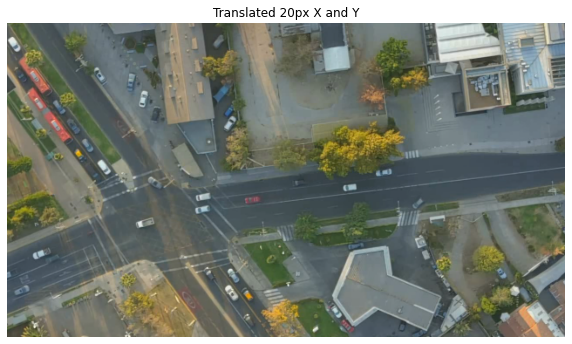

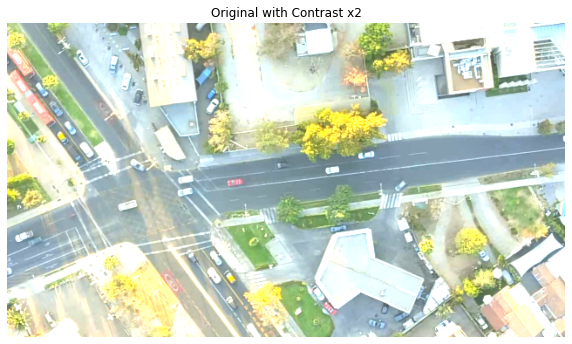

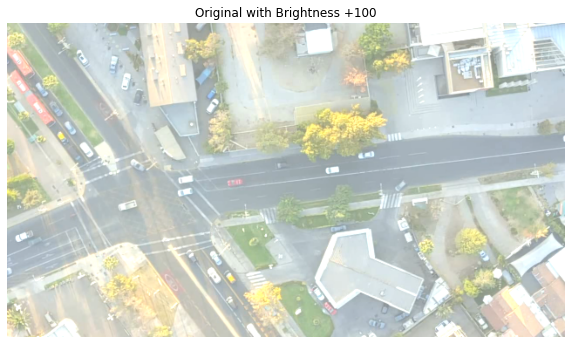

In [74]:
image = cv2.imread('./utilidades/benchmark_reference_study_frame.png')

im_height, im_width, _ = image.shape
window_height = int(im_height / 3)
window_width = int(im_width / 3)

window = extract_rotate_translate_window(image, window_width, window_height, 'Original')
rotated_window = extract_rotate_translate_window(image, window_width, window_height, "Rotated 10deg", gamma=10)
translated_window = extract_rotate_translate_window(image, window_width, window_height, "Translated 20px X and Y", dx=20, dy=20)

# Add contrast to the window
contrast_window = cv2.addWeighted(window, 2, np.zeros(window.shape, window.dtype), 0, 0)
imshow(contrast_window, title="Original with Contrast x2")

# Add brightness to the window
brightness_window = cv2.addWeighted(window, 1, np.zeros(window.shape, window.dtype), 0, 100)
imshow(brightness_window, title="Original with Brightness +100")


### Paso 2: Evaluar 

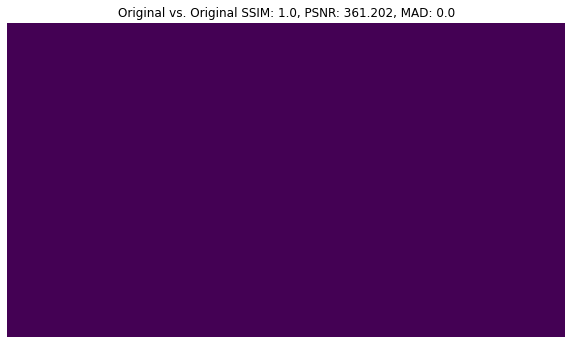

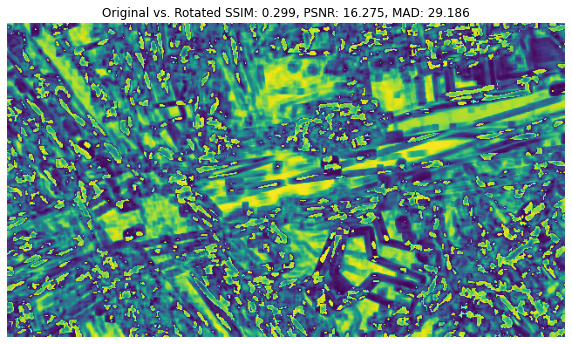

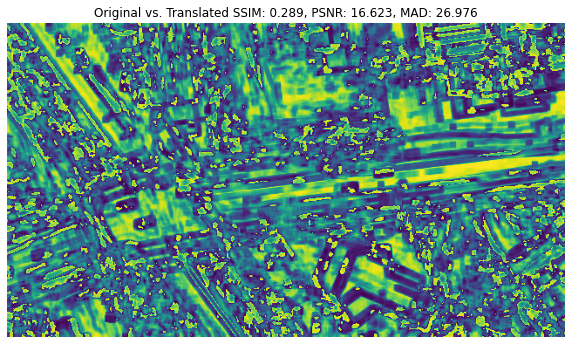

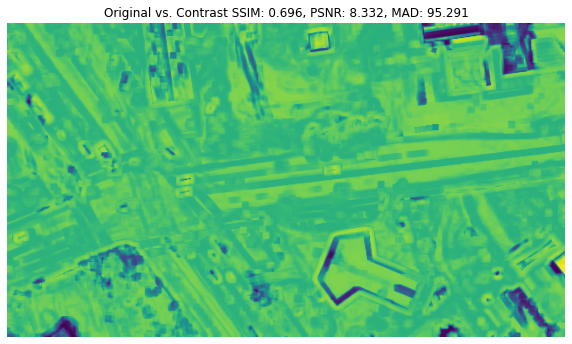

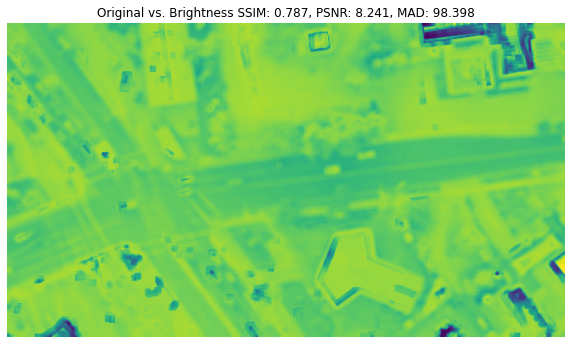

In [88]:
from skimage.metrics import structural_similarity as compare_ssim

def compare_images(image1, image2, title):
    # Convert the images to grayscale
    image1_gray = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    image2_gray = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

    # Compute the Structural Similarity Index (SSIM) between the two images, ensuring that the difference image is returned
    (score, diff) = compare_ssim(image1_gray, image2_gray, full=True)
    diff = (diff * 255).astype("uint8")

    psnr = cv2.PSNR(image1, image2)

    # Compute the absolute difference between the two images
    absdiff = cv2.absdiff(image1, image2)
    mad = np.mean(absdiff)

    # Print the score and return the diff image
    imshow(diff, title=title + f" SSIM: {round(score, 3)}, PSNR: {round(psnr, 3)}, MAD: {round(mad, 3)}")

compare_images(window, window, "Original vs. Original")
compare_images(window, rotated_window, "Original vs. Rotated")
compare_images(window, translated_window, "Original vs. Translated")
compare_images(window, contrast_window, "Original vs. Contrast")
compare_images(window, brightness_window, "Original vs. Brightness")